## Лабораторна робота. Логістична регресія

## 1
Розглянемо дані медичної страхової фірми. На основі характеристик пацієнтів `Members.csv` (вік, стать) та даних про отримання медичного обслуговування в попередньому році `Claims_Y1.csv` (медичний заклад, лікар, тип проблеми, кількість днів госпіталізації, дата та ін.) потрібно передбачити факт госпіталізації хоча б на 1 день наступного року `DaysInHospital_Y2.csv`.


In [78]:
import pandas as pd

from sklearn import *
from sklearn import metrics, model_selection, linear_model

%matplotlib inline
import matplotlib.pyplot as plt

Прочитайте дані, в якості параметру index_col використовуйте `MemberID`.

* дані з таблиці 'DaysInHospital_Y2.csv' у змінну `days2`
* дані з таблиці 'Members.csv' до змінної `m`
* дані з таблиці 'Claims_Y1.csv' у змінну `claims`

In [79]:
days2 = pd.read_csv('DaysInHospital_Y2.csv', index_col='MemberID')
m = pd.read_csv('Members.csv', index_col='MemberID')
claims = pd.read_csv('Claims_Y1.csv', index_col='MemberID')

## 2
Щоб анонімізувати дані організатор вказав приблизну інформацію про пацієнтів, наприклад, у стовпці вік зазначені вікові групи: '0-9', '10-19', '20-29', '30-39', '40-49', '50 -59', '60-69', '70-79', '80+'. Перетворимо рядкові ознаки на кількісні та замінимо пропущені значення:  AgeAtFirstClaim - значенням -1, Sex - N, LengthOfStay - 0.


In [80]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i, 'AgeAtFirstClaim'] = m.loc[i, 'AgeAtFirstClaim'].apply(lambda s: s.split('-')[0] if s != '80+' else '80')
m.loc[i, 'AgeAtFirstClaim'] = m.loc[i, 'AgeAtFirstClaim'].apply(lambda s: int(s))

m.AgeAtFirstClaim.fillna(-1, inplace=True)
m.Sex.fillna('N', inplace=True)

claims.LengthOfStay.fillna(0, inplace=True)
claims.CharlsonIndex = claims.CharlsonIndex.map({'0': 0, '1-2': 1, '3-4': 3, '5+': 5})

claims.LengthOfStay = claims.LengthOfStay.map({
    0: 0, '1 day': 1, '2 days': 2, '3 days': 3, '4 days': 4, '5 days': 5, '6 days': 6, '1- 2 weeks': 10, '2- 4 weeks': 21,
    '4- 8 weeks': 42, '26+ weeks': 182
})

## 3
Сконструюємо ознаки по масиву випадків медичного обслуговування:
* `f_Charlson` - максимальний індекс коморбідності Чальсона з усіх випадків для пацієнта (`CharlsonIndex` у таблиці `claims`)
* `f_LengthOfStay` - сумарна кількість днів госпіталізації минулого року (`LengthOfStay` у таблиці `claims`)

*Функції, які можуть стати в нагоді при розв'язанні: `.groupby(['MemberID']), .max(), .sum()`*

In [81]:
f_Charlson = claims.groupby('MemberID')['CharlsonIndex'].max()

f_LengthOfStay = claims.groupby('MemberID')['LengthOfStay'].sum()

## 4

Складемо матрицю об'єктів ознак зі стовпцями: `f_Charlson`, `f_LengthOfStay`, вік пацієнта, `ClaimsTruncated` (не виявилося випадків медичного обслуговування занадто багато):

*Функції, які можуть стати в нагоді при вирішенні: `.join()`*


In [82]:
data = days2.join(f_Charlson).join(f_LengthOfStay).join(m[['AgeAtFirstClaim']])
data['ClaimsTruncated'] = days2['ClaimsTruncated']
data['DaysInHospital'] = (days2['DaysInHospital'] > 0).astype(int)

m = pd.get_dummies(m, columns=['Sex'], prefix='pol')

data = data.join(m[['pol_F', 'pol_M', 'pol_N']])

print(data.head(5))

          ClaimsTruncated  DaysInHospital  CharlsonIndex  LengthOfStay  \
MemberID                                                                 
98324177                0               0              0             0   
33899367                1               1              0             0   
5481382                 0               1              0             0   
69908334                0               0              0             0   
29951458                0               0              0             0   

          AgeAtFirstClaim  pol_F  pol_M  pol_N  
MemberID                                        
98324177               30  False   True  False  
33899367               80   True  False  False  
5481382                20   True  False  False  
69908334               60   True  False  False  
29951458               40  False   True  False  


## 5
Складемо функцію, яка ділитиме вибірку на дві частини `dataTrain` та `dataTest`, буде навчати логістичну регресію на `dataTrain`, застосовувати до `dataTest`, будувати криву помилок і рахувати під нею площу:


In [83]:
def calcAUC(data):
    dataTrain, dataTest = model_selection.train_test_split(data, test_size=0.3, random_state=42)
    
    model = linear_model.LogisticRegression()
    model.fit(dataTrain.drop(columns='DaysInHospital'), dataTrain['DaysInHospital'])
    
    predictionProb = model.predict_proba(dataTest.drop(columns='DaysInHospital'))
    
    fpr, tpr, _ = metrics.roc_curve(dataTest['DaysInHospital'], predictionProb[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()
    
    print(metrics.roc_auc_score(dataTest['DaysInHospital'], predictionProb[:, 1]))

## 6
Застосуємо цю функцію до `data`:

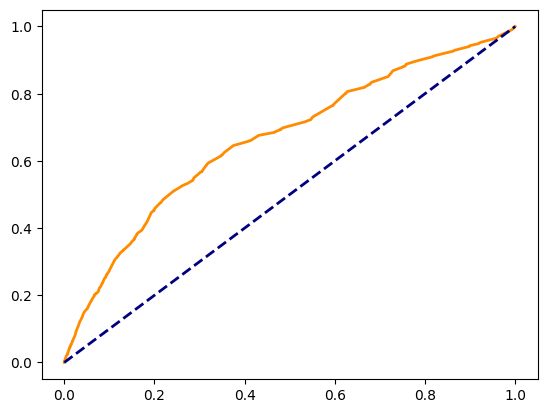

0.6636908195150393


In [84]:
calcAUC(data)

## 7

Логістична регресія приймає на вхід лише кількісні ознаки.

Додамо до наших даних стать пацієнта, застосувавши one hot encoding (ознайомитеся з даним методом кодування, опишіть його недоліки та переваги):

*Функції, які можуть стати в нагоді при розв'язанні: `pd.get_dummies(m.Sex, prefix='pol')`*



In [85]:
m = pd.read_csv('Members.csv')
data = pd.read_csv('DaysInHospital_Y2.csv')
claims = pd.read_csv('Claims_Y1.csv')

m = pd.get_dummies(m, columns=['Sex'], prefix='pol')

data = data.set_index('MemberID').join(m.set_index('MemberID')[['pol_F', 'pol_M']])

print(data.head())

          ClaimsTruncated  DaysInHospital  pol_F  pol_M
MemberID                                               
98324177                0               0  False   True
33899367                1               1   True  False
5481382                 0               1   True  False
69908334                0               0   True  False
29951458                0               0  False   True


## 8

Застосуйте one hot encoding до вже існуючих в `data` ознак та скласти нові ознаки за масивом `claims`.



In [86]:
data = pd.read_csv('DaysInHospital_Y2.csv')
claims = pd.read_csv('Claims_Y1.csv')

claims_counts = claims.groupby('MemberID').size().reset_index(name='TotalClaims')

data = data.merge(claims_counts, on='MemberID', how='left')

claims_one_hot = pd.get_dummies(claims[['MemberID', 'Specialty']], columns=['Specialty'])
claims_specialty = claims_one_hot.groupby('MemberID').sum().reset_index()

data = data.merge(claims_specialty, on='MemberID', how='left')


Побудуйте матрицю об'єктів ознак, для якої логістична регресія працює з найкращою якістю

Score:  0.6464300674892223


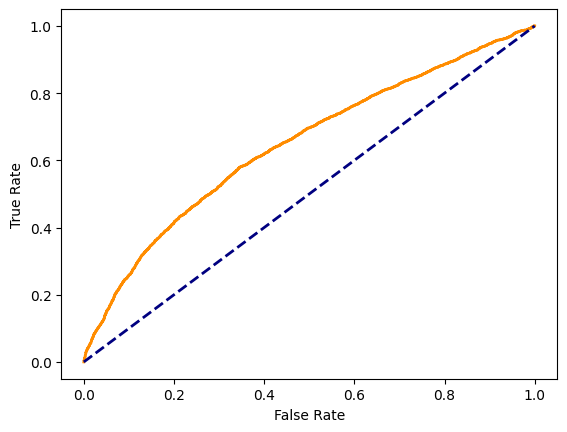

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve


data.fillna(0, inplace=True)
X = data.drop(columns=['DaysInHospital'])
y = data['DaysInHospital']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

predictionProb = model.predict_proba(X_test_scaled)
auc_score = roc_auc_score(y_test, predictionProb[:, 1])
print('Score: ', auc_score)

fpr, tpr, _ = roc_curve(y_test, predictionProb[:, 1])
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Rate')
plt.ylabel('True Rate')
plt.show()